In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores (working with actual data)


# Save the query results as a Pandas DataFrame and set the index to the date column 
precipitation_df = pd.DataFrame(rain_results, columns=['Date','Precipitation'])
precipitation_df.set_index('Date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot().get_figure()



SyntaxError: invalid syntax (<ipython-input-15-54f97e081557>, line 11)

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitatio
 df.describe()

IndentationError: unexpected indent (<ipython-input-40-b47d7d54f58a>, line 2)

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

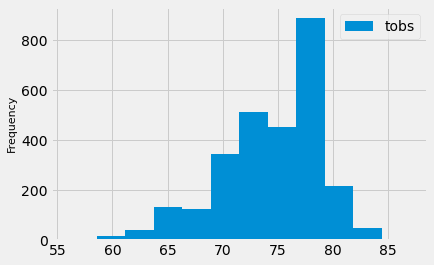

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
     filter(Measurement.date >= last_year).\
    group_by(Measurement.date).all()

# Put data into dataframe so it can be plotted as histogram
temp_results_df = pd.DataFrame(data=temp_results, columns=["date", "tobs"])
temp_results_df = temp_results_df.set_index('date', drop=True)

#Plot the results as a histogram with bins=12
plt.hist(temp_results_df['tobs'],12, label="tobs")
plt.ylabel("Frequency", fontsize=11)
plt.legend()
plt.show()

In [21]:
def calc_temps(start_date, end_date):
    select = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*select).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)

# calculate the min/max/avg from last year that matches my trip date
data = calc_temps((trip_arrive-last_year), (trip_leave-last_year))

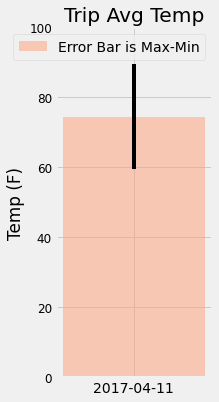

In [23]:
# Put the results into a dataframe so that it can be plotted
bar_trip_df = pd.DataFrame(data=data, columns=["date","tmin", "tavg", "tmax"])
bar_trip_df = bar_trip_df.set_index('date', drop=True)

#Create variables for my plot
plot_date = bar_trip_df.index.values
plot_tmin = bar_trip_df['tmin']
plot_tavg = bar_trip_df['tavg']
plot_tmax = bar_trip_df['tmax']

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
diff = bar_trip_df['tmax'] - bar_trip_df['tmin']
plt.figure(figsize=[2.5, 6])
pavg = plt.bar(plot_date, plot_tavg, yerr=diff, color="lightsalmon", alpha=.5, label="Error Bar is Max-Min")
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.legend()
plt.yticks(np.arange(0, 120, 20), fontsize=12)
plt.show()

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

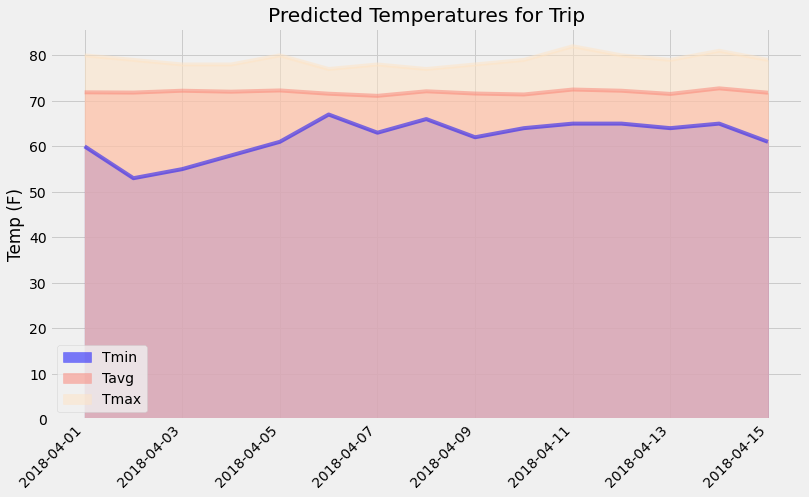

In [26]:
# create a list of dates for your trip 
trip_dates = pd.date_range(trip_arrive, trip_leave)

# format it to %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')

# calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_mmdd:
    # call daily_normals function to return the tuple list
    normals_list.append(*daily_normals(trip_date))

# make a normal df from the normals list
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
# make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

# Now plot the results 
# the colors list
colors = ['blue', 'salmon', 'bisque']

normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, alpha=.5, title='Predicted Temperatures for Trip', rot=45)
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.show()

In [27]:
def calc_temps(start_date, end_date):
    
    temps = session.query(Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).all()
    
    minimum_temp = min(temps)
    average_temp = np.mean(temps)
    maximum_temp = max(temps)
    
    print(f'minimum temperature = {minimum_temp}')
    print(f'average temperature = {average_temp}')
    print(f'maximum temperature = {maximum_temp}')
    
calc_temps("2017-08-23", "2018-08-23")

minimum temperature = (76.0,)
average temperature = 80.25
maximum temperature = (82.0,)


In [28]:
# 1. Identify key statistical data in June 
# across all of the stations and years using the describe() function.
# temperatures
temps = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime('%m',Measurement.date) == '06').all()
temps_df = pd.DataFrame(temps, columns=['Date','Temperature (F)'])
# precipitates
prcps = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime('%m',Measurement.date) == '06').all()
prcps_df = pd.DataFrame(prcps, columns=['Date','Precipitation'])

In [29]:
temps_df

,Date,Temperature (F)
0,2010-06-01,78.0
1,2010-06-02,76.0
2,2010-06-03,78.0
3,2010-06-04,76.0
4,2010-06-05,77.0
...,...,...
1695,2017-06-26,79.0
1696,2017-06-27,74.0
1697,2017-06-28,74.0
1698,2017-06-29,76.0


In [30]:
### ---------------------- OPTIONAL PART 1 -------------------------------------------------------------------
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    select = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*select).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Close session

In [31]:
temps_df.describe()

,Temperature (F)
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


In [32]:
prcps_df

,Date,Precipitation
0,2010-06-01,0.00
1,2010-06-02,0.01
2,2010-06-03,0.00
3,2010-06-04,0.00
4,2010-06-05,0.00
...,...,...
1695,2017-06-26,0.02
1696,2017-06-27,0.10
1697,2017-06-28,0.02
1698,2017-06-29,0.04


In [33]:
prcps_df.describe()

,Precipitation
count,1574.000000
mean,0.136360
std,0.335731
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.430000


In [34]:
# 2. Identify key statistical data in December 
# across all stations and years using the describe() function.
temps = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime('%m',Measurement.date) == '12').all()
temps_df = pd.DataFrame(temps, columns=['Date','Temperature (F)'])
# precipitates
prcps = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime('%m',Measurement.date) == '12').all()
prcps_df = pd.DataFrame(prcps, columns=['Date','Precipitation'])


In [35]:
temps_df

,Date,Temperature (F)
0,2010-12-01,76.0
1,2010-12-03,74.0
2,2010-12-04,74.0
3,2010-12-06,64.0
4,2010-12-07,64.0
...,...,...
1512,2016-12-27,71.0
1513,2016-12-28,71.0
1514,2016-12-29,69.0
1515,2016-12-30,65.0


In [36]:
temps_df.describe()

,Temperature (F)
count,1517.000000
mean,71.041529
std,3.745920
min,56.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000


In [37]:
prcps_df

,Date,Precipitation
0,2010-12-01,0.04
1,2010-12-03,0.00
2,2010-12-04,0.00
3,2010-12-06,0.00
4,2010-12-07,0.00
...,...,...
1512,2016-12-27,0.14
1513,2016-12-28,0.14
1514,2016-12-29,1.03
1515,2016-12-30,2.37


In [38]:
prcps_df.describe()

,Precipitation
count,1405.000000
mean,0.216819
std,0.541399
min,0.000000
25%,0.000000
50%,0.030000
75%,0.150000
max,6.420000
